## Delayed mode data

What if the Real-Time (RT) quality control is not enough?, or if we need the previous data of the float and the data from its neighbors to discern between subtle sensor malfunctioning and natural variability?.

This is where the second data quality control comes in. It is called **Delayed - Mode (DM)** quality control. Principal investigators and regional data experts are in charge of this meticulous task since it requires a more elaborate specific data analysis of every float and oceanographic expertise in the region where the float was deployed.  

### Delayed mode files

Delayed mode profile files are the same as the Real-Time profile files, except their file names on the GDACs all contain a “D” before the WMO number (e.g. D5900400_001.nc, BD5904179_001.nc). These profile files contain delayed mode - also called adjusted- data, which are recorded in the variable `<PARAM>_ADJUSTED`. The variable `DATA_MODE` will record ‘D’. Two other variables are also filled in delayed mode, which are `<PARAM>_ADJUSTED_QC` and `<PARAM>_ADJUSTED_ERROR``, which record the delayed mode quality control flags and the delayed mode adjustment uncertainty.

Core Argo delayed mode files are available 1 – 2 years after a profile is taken; sometimes earlier. These have been subjected to detailed scrutiny by oceanographic experts and the adjusted salinity has been estimated by comparison with high-quality ship-based CTD data and Argo data in the neighborhood and usingprocess described by  [Owens and Wong, 2009](https://www.sciencedirect.com/science/article/pii/S0967063708002021?via%3Dihub) and  [Cabanes et al, 2016](https://www.sciencedirect.com/science/article/pii/S0967063715301436) 

For BGC parameters, delayed mode files can be available within 5 – 6 cycles after deployment.  This is because the BGC sensors often return data that are out of calibration, but early adjustment methodologies exist that can significantly improve their accuracy. Additional delayed mode quality control occurs when a longer record of float data is available.

Therefore, gor each parameter, there are two variables associated with it: a raw version and an adjusted version.  The raw version can be found in the “PARAM” variable (e.g. `TEMP`, `PRES`, `DOXY`) and the adjusted version can be found in the “PARAM_ADJUSTED” variable (e.g. `TEMP_ADJUSTED`, `PRES_ADJUSTED`, `DOXY_ADJUSTED`).

### Quality Control flags

Each observation after the DM quality control has a QC flag associated, described in the Table 2: quality control flag scale of the [Argo user’s manual](https://archimer.ifremer.fr/doc/00187/29825/)) and assigned in real-time or delayed mode according to the [Argo Quality Control Manual for CTD and Trajectory Data](https://archimer.ifremer.fr/doc/00228/33951/). A summary of the meaning of the QC flags, a number from 0 to 9, is described in the following table:


|QCflag|Meaning|Real time description|Adjusted description|
|:----:|:-----:|:-------------------:|:------------------:|
|0 |No QC performed|No QC performed|No QC is performed.|
|1 |Good data|Good data. All Argo real-time QC tests passed. These measurements are good within the limits of the Argo real-time QC tests|Good data. No adjustment is needed, or the adjusted value is statistically consistent with good quality reference data. An error estimate is supplied|
|2 |Probably good data|	Probably good data. These measurements are to be used with caution |Probably good data. Delayed- mode evaluation is based on insufficient information. An error estimate is supplied.|
|3 |Probably bad data that are potentially adjustable|Probably bad data. These measurements are not to be used without scientific adjustment, e.g. data affected by sensor drift but may be adjusted in delayed-mode.|Probably bad data. An adjustment may (or may not) have been applied, but the value may still be bad. An error estimate is supplied.|
|4 |Bad data|Bad data. These measurements are not to be used. A flag '4' indicates that a relevant real- time qc test has failed. A flag '4' may also be assigned for bad measurements that are known to be not adjustable, e.g. due to sensor failure.|Bad data. Not adjustable. Adjusted data are replaced by FillValue.|
|5 |Value changed|Value changed|Value changed|
|6 |Not used |Not used|Not used|
|7 |Not used |Not used|Not used|
|8 |Estimated |Estimated value (interpolated, extrapolated or other estimation)|Estimated value (interpolated, extrapolated, or other estimation)|
|9 |Missing value|Missing value|Missing value. Data parameter will record FillValue|

### QC flags for data accessed by float

In [3]:
import numpy as np
import netCDF4
import xarray as xr

import cartopy.crs as ccrs
import cartopy

import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
qcmap = mpl.colors.ListedColormap(['#000000', '#31FC03', '#ADFC03', '#FC9103', '#FC1C03',
                                   '#324CA8', '#000000', '#000000', '#B22CC9', '#000000'])
def colorbar_qc(cmap, **kwargs):
    """Adjust colorbar ticks with discrete colors for QC flags"""
    ncolors = 10
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    return colorbar

Let's open the netCDF file of all the profiles for one float:

In [7]:
iwmo = 1900379
file=f"../../Data/dac/coriolis/{iwmo}/{iwmo}_prof.nc"
prof = xr.open_dataset(file)

and plot the real time data and the delayed mode data, to see the difference and the result of the processes:

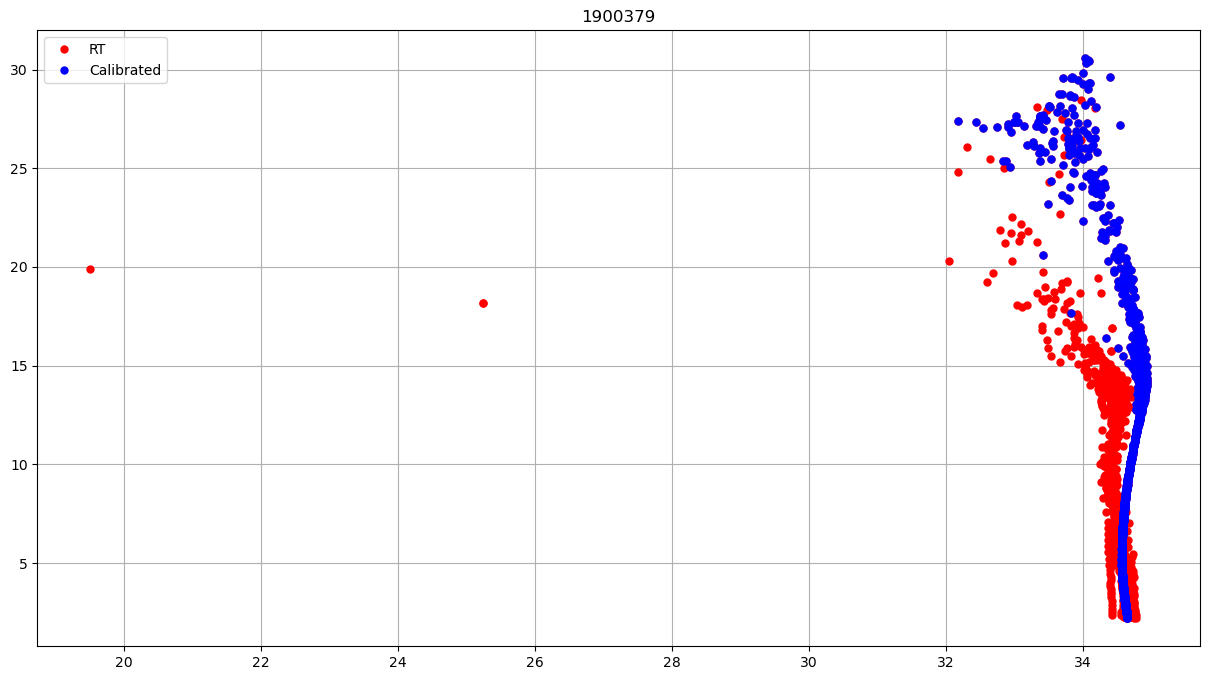

In [13]:
fig, ax = plt.subplots(figsize=(15,8)) 
ax.plot(prof.PSAL[0], prof.TEMP[0], 'ro', markersize=5, label='RT')
ax.plot(prof.PSAL_ADJUSTED[0], prof.TEMP_ADJUSTED[0], 'bo',markersize=5, label='Calibrated')

ax.plot(prof.PSAL, prof.TEMP, 'ro', markersize=5)
ax.plot(prof.PSAL_ADJUSTED, prof.TEMP_ADJUSTED, 'bo',markersize=5)
ax.set_title(f"{iwmo}")
ax.legend()
ax.grid()

and of course, we can inspect the quality flags of the corrected data

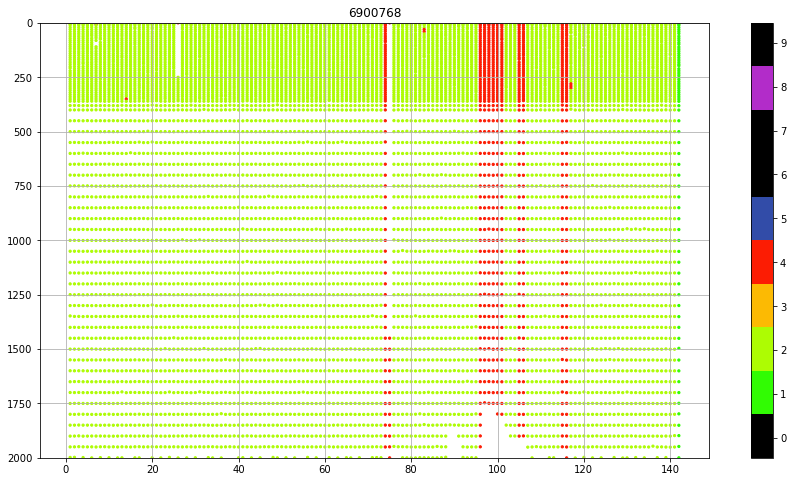

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
sc = ax.scatter(prof.CYCLE_NUMBER+prof.PRES*0, 
                prof.PRES_ADJUSTED, 
                c=prof.PSAL_ADJUSTED_QC, vmin=0, vmax=9, cmap=qcmap, s=5)
colorbar_qc(qcmap, ax=ax)
ax.set_title(f"{iwmo}")
ax.grid()
ax.set_ylim(0,2000)
ax.invert_yaxis()   

and for instance, just use the 'best' data:

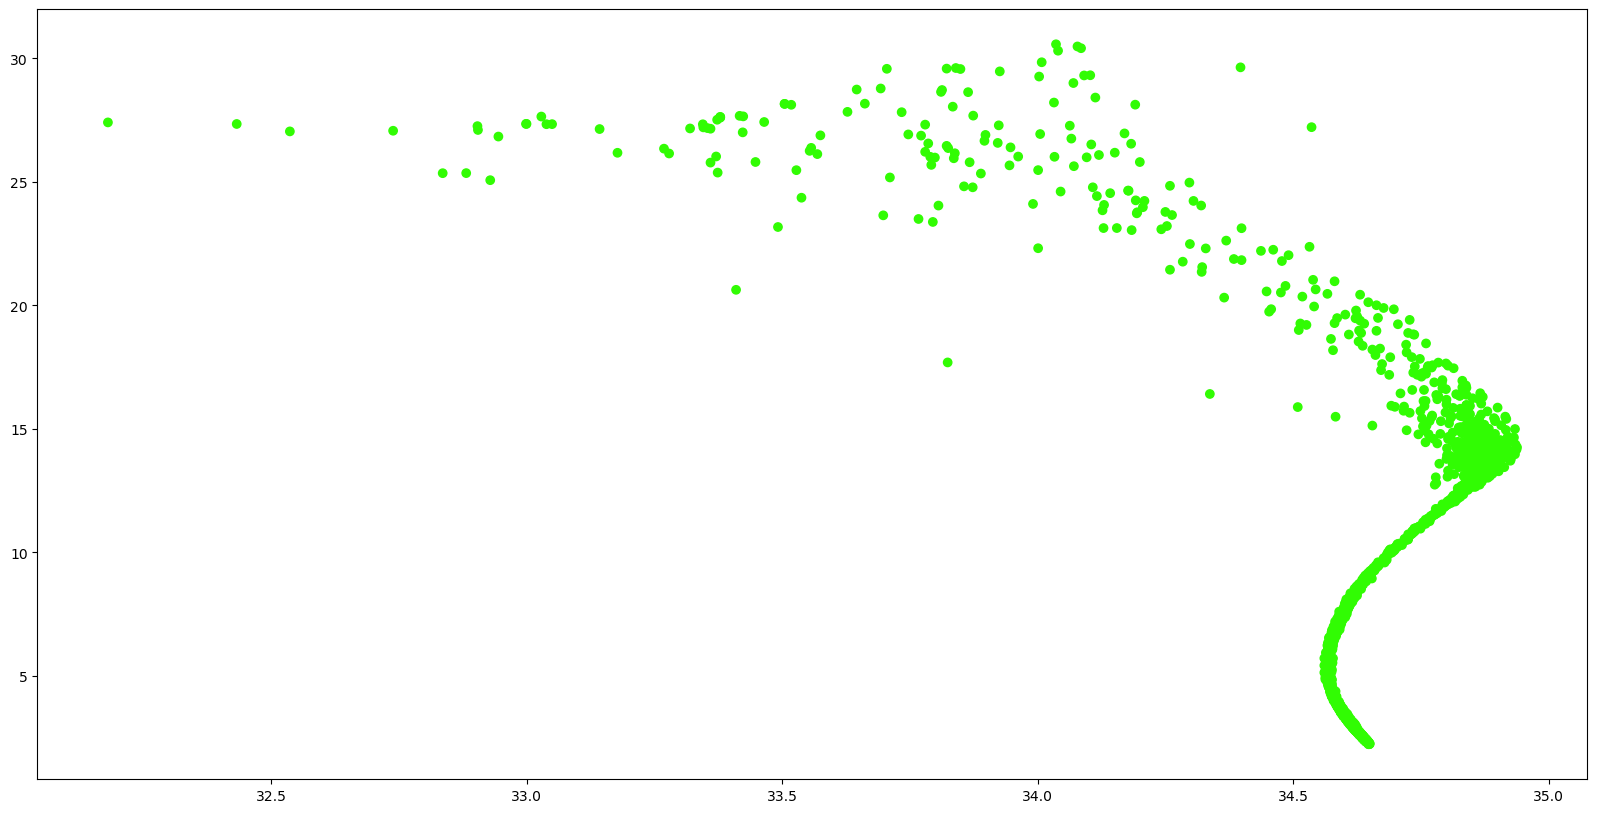

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
sc = ax.scatter(prof.PSAL_ADJUSTED.where(prof.PSAL_ADJUSTED_QC.values.astype(float) == 1), 
                prof.TEMP_ADJUSTED.where(prof.PSAL_ADJUSTED_QC.values.astype(float) == 1), 
                c=prof.PSAL_ADJUSTED_QC.where(prof.PSAL_ADJUSTED_QC.values.astype(float) == 1), vmin=0, vmax=9, cmap=qcmap)
